In this notebook, we will implement a simple baseline for clustering log files based on the embeddings found in `data/log_embeddings`
generated by the `scripts/embed_mlchallenge_data.py` script.

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from pathlib import Path
import pandas as pd
import json
from tqdm import tqdm
from ml_challenge.utils import evaluate_submission_file, generate_submission_file 
from ml_challenge.utils import get_log_paths, get_log_fnames, repo_path

In [50]:

# load logs paths
log_files = get_log_paths()
# get logs stem (for generating submission files) 
log_fnames = get_log_fnames()

In [51]:
# First, let's see how a random clustering submission would perform
# From prior knowledge of the log files, it is estimated that the number of clusters is around 5
# Let's see how it performs
def random_clustering_submission(n_clusters, fnames):
    labels = [np.random.randint(n_clusters) for i in range(len(fnames))]
    return labels

log_labels = random_clustering_submission(2, log_files)


# Generate submission file
submission_path = str(Path(repo_path / "data" / "mlchallenge_submissions" / "random_submission.csv"))
groundtruth_path = str(Path(repo_path / "data" / "log_metadata" / "mlchallenge_labels.csv"))
generate_submission_file(log_fnames, log_labels, submission_path)
random_result = evaluate_submission_file(submission_path, groundtruth_path)
print(random_result)

Submission file saved to C:\Users\AParmar2\Documents\ml_challenge_as24-master\data\mlchallenge_submissions\random_submission.csv
{'homogeneity': 0.026905338826163375, 'normalized_mutual_info': 0.021901735074456627, 'adjusted_rand_index': -4.827090229200602e-05}


In [52]:
# Second, let's make pretend we have access to the true labels and evaluate that as a submission
# to get a sense of the upper bound of the metrics
gt_result = evaluate_submission_file(groundtruth_path, groundtruth_path)
print(gt_result)


{'homogeneity': 1.0, 'normalized_mutual_info': 1.0, 'adjusted_rand_index': 1.0}


In [53]:
# Finally, let's get to the gist of this notebook, clustering the log files based on their embeddings
# that we generated by `scripts/embed_mlcahllenge_data.py`
# Note that the embeddings are stored in the `log_embeddings` directory
# Note also that this is not the only way to embed these log files,
# Check the `scripts/embed_mlcahllenge_data.py` for more details.
# We use a simple text chunking method to chunk the log files into smaller pieces and then each piece is embedded.
# As a result, an embedding file contain an mxn matrix where m is the number of chunks and n is the embedding dimension.

# In the following, we load the embeddings and cluster them using spectral clustering
# based on a simple distance metric that measures the similarity between the two sets of embeddings (m1xn and m2xn)
# were m1 and m2 are not necessarily equal (as log files can be of different lengths)
# Path to the embeddings directory
embeddings_dir = Path(repo_path / "data" / "log_embeddings")


In [54]:
# load all embeddings (while your computer memory allows)
# and the corresponding file names (to be used later for generating the submission file)
embeddings = []
fnames = []
for embedding_file in tqdm(embeddings_dir.iterdir()):
    data = np.load(embedding_file)
    embeddings.append(data)
    fnames.append(embedding_file.stem + '.log')
embeddings_df = pd.DataFrame({'fname':fnames, 'embedding': embeddings})

0it [00:00, ?it/s]


EOFError: No data left in file

In [8]:
# let's see how the embeddings look like for two random log files
i, j = np.random.choice(range(len(embeddings_df)), 2)
A = embeddings_df['embedding'][i]
B = embeddings_df['embedding'][j]

In [1]:
# let's define a distance/similarity metric between two sets of embeddings
# we use the RV coefficient as a measure of similarity between two sets of embeddings
# Refer to https://arxiv.org/pdf/1307.7383 for more details.

def compute_rv_coefficient(A, B):
    X = A.T.dot(A)
    Y = B.T.dot(B)
    # equation 2 in the paper https://arxiv.org/pdf/1307.7383
    correlation = np.trace(X @ Y) / (np.trace(X) * np.trace(Y))
    # for distance, we return 1 - correlation
    # some algorithms accepts an affinity matrix, so we can use the correlation directly
    return correlation

In [10]:
# let's pre-compute the affinity matrix between all pairs of log files based on the distance metric defined above

affinity = np.ones((embeddings_df.shape[0], embeddings_df.shape[0]))
for i in tqdm(range(embeddings_df.shape[0])):
    for j in range(i+1, embeddings_df.shape[0]):
        affinity[i,j] = compute_rv_coefficient(embeddings_df['embedding'][i], embeddings_df['embedding'][j])
        affinity[j,i] = affinity[i,j]

100%|██████████| 792/792 [14:54<00:00,  1.13s/it]


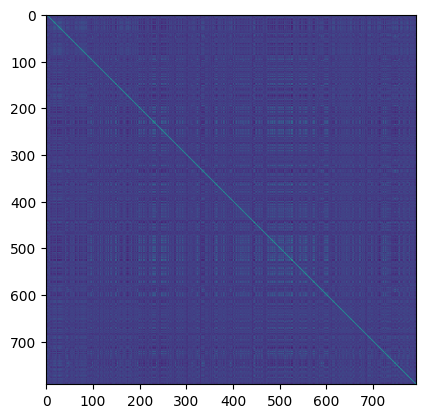

In [11]:
# let's visualize the affinity matrix
# this affinity matrix is symmetric and has a diagonal of ones
# the diagonal of ones is because the similarity between a log file and itself is 1
assert np.allclose(np.diag(affinity), 1)
_ = plt.imshow(affinity)

In [12]:
from sklearn.cluster import spectral_clustering

log_sc_labels = spectral_clustering(n_clusters=5, affinity=affinity)
sc_submission_path = str(Path(repo_path / "data" / "mlchallenge_submissions" / "spectral_clustering_submission.csv"))
generate_submission_file(fnames, log_sc_labels, submission_path)


Submission file saved to /Users/Ash.AlDujaili/workspace/playground/ml_challenge_as24/data/mlchallenge_submissions/random_submission.csv


In [13]:
# let's evaluate the submission
sc_result = evaluate_submission_file(sc_submission_path, groundtruth_path)
print(sc_result)

{'homogeneity': 0.4115487415609386, 'normalized_mutual_info': 0.45062164694004103, 'adjusted_rand_index': 0.2944094705717369}


This should be enough to get you started with this challenge.

Please note that this year's challenge fits more an `unsupervised learning` framework than that of a supervised one.

In the sense that we do not really have a labeled dataset. 

All we have is a bunch of log files with some intuititon/prior knowledge on how many clusters they belong to (around 4-8 clusters)

and a labelling of some of these log files (provided in `data/log_metadata/mlchallenge.csv`) that is considered good but still not perfect.

From here, there are several possible approaches to investiagte.
1. Embedding logic: the current chunking strategy of the log files does not consider the semantic content and structure of the files. Is there a better alternative? One further question, is embedding even required? Can one inspect these log files and figure out a better alternative of featurizing them?
2. Distance/Similarity between log files embeddings: In the above notebook, we made use of a correlation measure between a pair of matrices. Such measure can detect linear relationships but not non-linear ones. Is there a better alternative? Also, we are trying to compute similarities between two `sets` of embeddings that can be of variable size and order. Is there a better alternative?
3. We did not touch on the scalability of the clustering pipeline. We assume everything fits in memory but that is something to think about.
4. Clustering Interpretability: can the clustering pipeline we create explain the decisions it takes to cluster the log files (e.g., by pointing to relevant lines into the log files, etc)?